In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
TRAIN_DIR = "/kaggle/input/deepglobe-land-cover-classification-dataset/train"
VALID_DIR = "/kaggle/input/deepglobe-land-cover-classification-dataset/valid"
TEST_DIR = "/kaggle/input/deepglobe-land-cover-classification-dataset/test"
COLOR_CODES = "/kaggle/input/deepglobe-land-cover-classification-dataset/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [4]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [5]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [6]:
img = cv2.imread("/kaggle/input/deepglobe-land-cover-classification-dataset/test/100877_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, _ = img.shape
print("Image size (height x width):", height, "x", width)

Image size (height x width): 2448 x 2448


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 


        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)

        return seg

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()

In [9]:
class Train():
    def __init__(self, model, dataloader, optimizer, num_epochs, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.loss = loss
    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_samples = 0
            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    labels = labels.squeeze().long()
                    loss = self.loss(predictions, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)
                    dl.set_postfix({"Epoch": epoch + 1, "Loss": total_loss / total_samples})
            epoch_loss = total_loss / total_samples
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}")

In [10]:
num_classes = len(label_map.keys())
lr = 0.001
batch_size = 16
model = UNet(n_class=num_classes)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 10
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = FocalLoss()

In [11]:
from torch.utils.data import DataLoader, random_split

train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders for training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|          | 0/46 [00:00<?, ?batch/s]/tmp/ipykernel_34/93752488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
100%|██████████| 46/46 [19:51<00:00, 25.90s/batch, Epoch=1, Loss=0.929]


Epoch [1/10], Loss: 0.9291


100%|██████████| 46/46 [19:47<00:00, 25.81s/batch, Epoch=2, Loss=0.842]


Epoch [2/10], Loss: 0.8418


100%|██████████| 46/46 [19:46<00:00, 25.80s/batch, Epoch=3, Loss=0.82] 


Epoch [3/10], Loss: 0.8196


100%|██████████| 46/46 [19:47<00:00, 25.82s/batch, Epoch=4, Loss=0.788]


Epoch [4/10], Loss: 0.7876


100%|██████████| 46/46 [19:46<00:00, 25.79s/batch, Epoch=5, Loss=0.744]


Epoch [5/10], Loss: 0.7444


100%|██████████| 46/46 [19:46<00:00, 25.80s/batch, Epoch=6, Loss=0.724]


Epoch [6/10], Loss: 0.7242


100%|██████████| 46/46 [19:49<00:00, 25.85s/batch, Epoch=7, Loss=0.693]


Epoch [7/10], Loss: 0.6932


100%|██████████| 46/46 [19:57<00:00, 26.02s/batch, Epoch=8, Loss=0.698]


Epoch [8/10], Loss: 0.6981


100%|██████████| 46/46 [19:54<00:00, 25.96s/batch, Epoch=9, Loss=0.674]


Epoch [9/10], Loss: 0.6737


100%|██████████| 46/46 [19:50<00:00, 25.87s/batch, Epoch=10, Loss=0.661]

Epoch [10/10], Loss: 0.6609


tensor([0, 1, 2, 3, 4, 5], device='cuda:0')


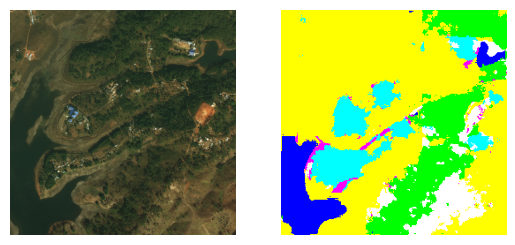

In [14]:
img = cv2.imread("/kaggle/input/deepglobe-land-cover-classification-dataset/test/100877_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()

In [15]:
import torch

def test(model, test_dataloader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to long integers if needed
            labels = labels.squeeze().long()

            predictions = model(inputs)

            # Convert predictions to label indices
            _, predicted_labels = torch.max(predictions, 1)

            # Ensure labels and predicted_labels are of the same type and shape
            correct = (predicted_labels == labels).sum().item()
            total_correct += correct
            total_pixels += labels.numel()

    if total_pixels == 0:
        print("No samples in the test set.")
        return

    test_accuracy = total_correct / total_pixels * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

test(model, test_dataloader, device)

Test Accuracy: 79.47%


In [16]:
torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()

UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(